In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [0]:
!pip3 install 'torch==0.4.1'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'

# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(00)

    100% |████████████████████████████████| 2.0MB 39.8MB/s 


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.utils
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print('done')

done


['baseball', 'basketball court', 'beach', 'circular farm', 'cloud', 'commercial area', 'dense residential', 'desert', 'forest', 'golf course', 'harbor', 'island', 'lake', 'meadow', 'medium residential area', 'mountain', 'rectangular farm', 'river', 'sea glacier', 'shrubs', 'snowberg', 'sparse residential area', 'thermal power station', 'wetland']


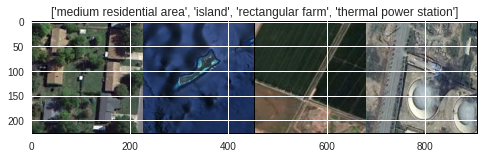

In [2]:
plt.ion()   # interactive mode

######################################################################
# Load Data
# ---------

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/My Drive/Habitats Dataset'
total_dataset = datasets.ImageFolder(data_dir,transform=data_transforms['train'])
class_names = total_dataset.classes
print(class_names)
split_ratio = 0.75
total_length = len(total_dataset)
lengths = [int(total_length*split_ratio) ,total_length-int(total_length*split_ratio)]

image_datasets=dict()
image_datasets['train'],image_datasets['val']  = data.random_split(total_dataset,lengths)

#print(len(train))
#print(len(val))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

model_conv = torchvision.models.resnet18(pretrained=True)
#for param in model_conv.parameters():
#    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 24)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.008, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Epoch 0/24
----------
train Loss: 1.8134 Acc: 0.4628
val Loss: 1.0521 Acc: 0.6834

Epoch 1/24
----------
train Loss: 1.3543 Acc: 0.6012
val Loss: 0.9300 Acc: 0.7171

Epoch 2/24
----------
train Loss: 1.2627 Acc: 0.6282
val Loss: 0.8731 Acc: 0.7442

Epoch 3/24
----------
train Loss: 1.2623 Acc: 0.6356
val Loss: 0.7727 Acc: 0.7719

Epoch 4/24
----------
train Loss: 1.2227 Acc: 0.6506
val Loss: 0.7967 Acc: 0.7668

Epoch 5/24
----------
train Loss: 1.2187 Acc: 0.6515
val Loss: 0.8473 Acc: 0.7648

Epoch 6/24
----------
train Loss: 1.2167 Acc: 0.6503
val Loss: 0.8622 Acc: 0.7543

Epoch 7/24
----------
train Loss: 0.9712 Acc: 0.7133
val Loss: 0.7427 Acc: 0.7859

Epoch 8/24
----------
train Loss: 0.9790 Acc: 0.7027
val Loss: 0.7130 Acc: 0.7925

Epoch 9/24
----------
train Loss: 0.9870 Acc: 0.7089
val Loss: 0.7440 Acc: 0.7683

Epoch 10/24
----------
train Loss: 0.9660 Acc: 0.7120
val Loss: 0.7445 Acc: 0.7779

Epoch 11/24
----------
train Loss: 0.9651 Acc: 0.7113
val Loss: 0.7208 Acc: 0.7764

Ep

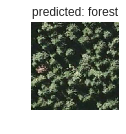

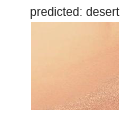

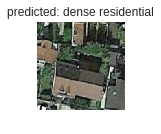

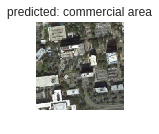

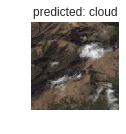

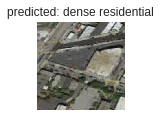

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f33b1d05748>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

In [9]:
######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)


In [0]:

torch.save(model_conv.state_dict(),'/content/gdrive/My Drive/Habitat_model')

plt.ioff()
plt.show()
